In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder


# Add these imports to your existing cell
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the cleaned data
train_transaction = pd.read_csv('../data/preprocessed/train_transaction_cleaned.csv')
train_identity = pd.read_csv('../data/preprocessed/train_identity_cleaned.csv')
test_transaction = pd.read_csv('../data/preprocessed/test_transaction_cleaned.csv')
test_identity = pd.read_csv('../data/preprocessed/test_identity_cleaned.csv')

print(f"Training data shape: {train_transaction.shape}")
print(f"Test data shape: {test_transaction.shape}")
print(train_transaction.columns)

# Combine transaction and identity data
train_data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_data = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
print(f"Train data shape after merge: {train_data.shape}")
print(f"Test data shape after merge: {test_data.shape}")
print(f"Fraud rate in training data: {train_data['isFraud'].mean():.4f}")


Training data shape: (590540, 410)
Test data shape: (506691, 409)
Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'TransactionDT_hour_sin', 'TransactionDT_hour_cos',
       'TransactionDT_dow_sin', 'TransactionDT_dow_cos',
       'TransactionDT_month_sin', 'TransactionDT_month_cos',
       'TransactionDT_is_weekend', 'TransactionDT_time_of_day',
       'TransactionDT_days_since_first', 'TransactionDT_seconds_since_first'],
      dtype='object', length=410)
Train data shape after merge: (593424, 450)
Test data shape after merge: (506691, 449)
Fraud rate in training data: 0.0348


In [43]:
# STEP 1: Enhanced Temporal Features (Fix your existing function)
def create_temporal_features(df):
    """Advanced temporal feature engineering with proper velocity calculation"""
    
    # Create a copy to avoid modifying original
    df = df.copy()
    
    # Ensure TransactionDT is numeric
    df['TransactionDT'] = pd.to_numeric(df['TransactionDT'], errors='coerce')
    
    # Basic time features
    df['TransactionDT_hour'] = (df['TransactionDT'] / 3600) % 24
    df['TransactionDT_day'] = (df['TransactionDT'] / (3600 * 24)) % 7
    df['TransactionDT_week'] = df['TransactionDT'] / (3600 * 24 * 7)
    
    # Ensure all time features are numeric
    df['TransactionDT_hour'] = pd.to_numeric(df['TransactionDT_hour'], errors='coerce').fillna(0)
    df['TransactionDT_day'] = pd.to_numeric(df['TransactionDT_day'], errors='coerce').fillna(0)
    df['TransactionDT_week'] = pd.to_numeric(df['TransactionDT_week'], errors='coerce').fillna(0)
    
    # Advanced temporal patterns
    df['is_weekend'] = df['TransactionDT_day'].isin([5, 6]).astype(int)
    df['is_night'] = ((df['TransactionDT_hour'] >= 22) | (df['TransactionDT_hour'] <= 6)).astype(int)
    df['is_business_hours'] = ((df['TransactionDT_hour'] >= 9) & (df['TransactionDT_hour'] <= 17)).astype(int)
    df['is_peak_hours'] = df['TransactionDT_hour'].isin([12, 13, 18, 19, 20]).astype(int)
    
    # Time since epoch features
    df['days_since_start'] = df['TransactionDT'] / (3600 * 24)
    df['hour_of_week'] = df['TransactionDT_day'] * 24 + df['TransactionDT_hour']
    
    # Sort by card and time for velocity calculations
    df = df.sort_values(['card1', 'TransactionDT']).reset_index(drop=True)
    
    # Fixed velocity features - count transactions in time windows
    for hours in [1, 24, 168]:  # 1 hour, 1 day, 1 week
        window_seconds = hours * 3600
        
        # Create velocity feature using a simpler approach
        velocity_list = []
        for card in df['card1'].unique():
            if pd.isna(card):  # Skip NaN card values
                continue
                
            card_data = df[df['card1'] == card].copy()
            card_data = card_data.sort_values('TransactionDT')
            
            # Calculate velocity for each transaction
            velocities = []
            for i, row in card_data.iterrows():
                current_time = row['TransactionDT']
                if pd.isna(current_time):  # Skip if time is NaN
                    velocities.append(1)
                    continue
                    
                time_window_start = current_time - window_seconds
                
                # Count transactions in the time window (including current)
                count = len(card_data[
                    (card_data['TransactionDT'] <= current_time) & 
                    (card_data['TransactionDT'] > time_window_start) &
                    (~pd.isna(card_data['TransactionDT']))
                ])
                velocities.append(max(count, 1))  # Ensure at least 1
            
            # Store velocities with original indices
            for idx, vel in zip(card_data.index, velocities):
                velocity_list.append((idx, vel))
        
        # Create velocity column
        velocity_dict = dict(velocity_list)
        df[f'velocity_{hours}h'] = df.index.map(velocity_dict).fillna(1)
    
    # Time between transactions
    df['time_since_last_txn'] = df.groupby('card1')['TransactionDT'].diff()
    df['time_to_next_txn'] = df.groupby('card1')['TransactionDT'].diff(-1).abs()
    
    # Fill NaN values for time differences
    df['time_since_last_txn'].fillna(0, inplace=True)
    df['time_to_next_txn'].fillna(0, inplace=True)
    
    # Cyclical encoding for hour and day
    df['hour_sin'] = np.sin(2 * np.pi * df['TransactionDT_hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['TransactionDT_hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['TransactionDT_day'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['TransactionDT_day'] / 7)
    
    return df

In [44]:
# STEP 2: Advanced Amount-Based Features
def create_amount_features(df):
    """Sophisticated amount-based features"""
    
    df = df.copy()
    
    # Ensure TransactionAmt is numeric
    df['TransactionAmt'] = pd.to_numeric(df['TransactionAmt'], errors='coerce').fillna(0)
    
    # Basic amount transformations
    df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])
    df['TransactionAmt_sqrt'] = np.sqrt(df['TransactionAmt'])
    df['TransactionAmt_decimal'] = df['TransactionAmt'] - df['TransactionAmt'].astype(int)
    df['is_round_amount'] = (df['TransactionAmt_decimal'] == 0).astype(int)
    
    # Amount patterns
    df['amount_digits'] = df['TransactionAmt'].astype(str).str.len()
    df['is_even_amount'] = (df['TransactionAmt'] % 2 == 0).astype(int)
    df['ends_with_00'] = (df['TransactionAmt'] % 100 == 0).astype(int)
    df['ends_with_99'] = (df['TransactionAmt'].astype(str).str.endswith('99')).astype(int)
    
    # Card-level amount statistics
    card_amt_stats = df.groupby('card1')['TransactionAmt'].agg([
        'mean', 'std', 'min', 'max', 'count', 'median',
        lambda x: np.percentile(x, 25),
        lambda x: np.percentile(x, 75)
    ]).reset_index()
    card_amt_stats.columns = ['card1', 'card_amt_mean', 'card_amt_std', 'card_amt_min', 
                             'card_amt_max', 'card_amt_count', 'card_amt_median',
                             'card_amt_q25', 'card_amt_q75']
    
    df = df.merge(card_amt_stats, on='card1', how='left')
    
    # Amount deviation features
    df['amt_deviation_from_mean'] = np.abs(df['TransactionAmt'] - df['card_amt_mean']) / (df['card_amt_std'] + 1e-6)
    df['amt_rank_within_card'] = df.groupby('card1')['TransactionAmt'].rank(pct=True)
    df['is_amt_outlier'] = (df['amt_deviation_from_mean'] > 2).astype(int)
    
    # Amount vs time patterns (ensure numeric operations)
    df['TransactionDT_hour'] = pd.to_numeric(df['TransactionDT_hour'], errors='coerce').fillna(0)
    df['is_weekend'] = pd.to_numeric(df['is_weekend'], errors='coerce').fillna(0)
    
    df['amt_per_hour'] = df['TransactionAmt'] / (df['TransactionDT_hour'] + 1)
    df['amt_weekend_ratio'] = df['TransactionAmt'] * df['is_weekend']
    
    return df

In [45]:
# STEP 3: Device Features
def create_device_features(df):
    """Create device and browser-based features"""
    
    df = df.copy()
    
    # Device type analysis
    if 'DeviceType' in df.columns:
        df['is_mobile'] = (df['DeviceType'] == 'mobile').astype(int)
        df['is_desktop'] = (df['DeviceType'] == 'desktop').astype(int)
    
    # Browser analysis
    if 'id_31' in df.columns:
        df['browser_type'] = df['id_31']
        # Common browsers
        common_browsers = ['chrome', 'safari', 'firefox', 'edge']
        df['is_common_browser'] = df['id_31'].str.lower().isin(common_browsers).astype(int)
    
    # Screen resolution
    if 'id_33' in df.columns:
        df['screen_width'] = df['id_33']
        df['is_common_resolution'] = df['id_33'].isin([1920, 1366, 1280, 1024]).astype(int)
    
    # Operating system
    if 'id_30' in df.columns:
        df['os_type'] = df['id_30']
        df['is_windows'] = df['id_30'].str.contains('Windows', na=False).astype(int)
        df['is_ios'] = df['id_30'].str.contains('iOS', na=False).astype(int)
        df['is_android'] = df['id_30'].str.contains('Android', na=False).astype(int)
    
    return df

In [46]:
# STEP 4: Frequency Encoding with Bayesian Smoothing
def frequency_encoding_with_smoothing(df, columns, target='isFraud', alpha=10):
    """Frequency encoding with Bayesian smoothing to prevent overfitting"""
    
    df = df.copy()
    global_fraud_rate = df[target].mean()
    
    for col in columns:
        if col in df.columns:
            # Calculate category statistics
            stats = df.groupby(col)[target].agg(['count', 'sum']).reset_index()
            stats.columns = [col, 'count', 'fraud_count']
            
            # Bayesian smoothing
            stats[f'{col}_fraud_rate_smooth'] = (
                (stats['fraud_count'] + alpha * global_fraud_rate) / 
                (stats['count'] + alpha)
            )
            
            # Frequency encoding
            stats[f'{col}_frequency'] = stats['count']
            
            # Merge back
            merge_cols = [col, f'{col}_fraud_rate_smooth', f'{col}_frequency']
            df = df.merge(stats[merge_cols], on=col, how='left')
            
            # Fill missing values with global stats
            df[f'{col}_fraud_rate_smooth'].fillna(global_fraud_rate, inplace=True)
            df[f'{col}_frequency'].fillna(1, inplace=True)
    
    return df

In [47]:
# STEP 5: Advanced Interaction Features
def create_interaction_features(df):
    """Create meaningful feature interactions"""
    
    df = df.copy()
    
    # Amount × Time interactions
    df['amt_hour_interaction'] = df['TransactionAmt'] * df['TransactionDT_hour']
    df['amt_weekend_interaction'] = df['TransactionAmt'] * df['is_weekend']
    df['amt_night_interaction'] = df['TransactionAmt'] * df['is_night']
    df['amt_business_interaction'] = df['TransactionAmt'] * df['is_business_hours']
    
    # Card × Product interactions
    if 'ProductCD' in df.columns:
        df['card_product_combo'] = df['card1'].astype(str) + '_' + df['ProductCD'].astype(str)
    
    # Address interactions
    if 'addr1' in df.columns and 'addr2' in df.columns:
        df['addr_combo'] = df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
        df['addr_mismatch'] = (df['addr1'] != df['addr2']).astype(int)
    
    # Email domain interactions
    if 'P_emaildomain' in df.columns and 'R_emaildomain' in df.columns:
        df['email_domain_match'] = (df['P_emaildomain'] == df['R_emaildomain']).astype(int)
        df['email_domains_combo'] = df['P_emaildomain'].astype(str) + '_' + df['R_emaildomain'].astype(str)
    
    # Card × Device interactions
    if 'id_31' in df.columns:
        df['card_browser_combo'] = df['card1'].astype(str) + '_' + df['id_31'].astype(str)
    
    # Distance features (if geographic data available)
    if 'dist1' in df.columns and 'dist2' in df.columns:
        df['dist_ratio'] = df['dist1'] / (df['dist2'] + 1e-6)
        df['dist_sum'] = df['dist1'] + df['dist2']
        df['dist_diff'] = np.abs(df['dist1'] - df['dist2'])
    
    # Amount percentile interactions
    df['amt_rank_hour_interaction'] = df['amt_rank_within_card'] * df['TransactionDT_hour']
    df['velocity_amt_interaction'] = df['velocity_1h'] * np.log1p(df['TransactionAmt'])
    
    return df

In [48]:
# STEP 6: Network and Anomaly Detection Features (UPDATED)
def create_network_anomaly_features(df, is_train=True, train_stats=None):
    """Create graph-based and anomaly detection features"""
    
    df = df.copy()
    
    # Email domain risk analysis
    if 'P_emaildomain' in df.columns:
        if is_train:
            # Calculate stats from training data
            email_stats = df.groupby('P_emaildomain')['isFraud'].agg(['mean', 'count']).reset_index()
            email_stats.columns = ['P_emaildomain', 'email_fraud_rate', 'email_frequency']
            df = df.merge(email_stats, on='P_emaildomain', how='left')
            
            # Store stats for test set
            if train_stats is not None:
                train_stats['email_stats'] = email_stats
        else:
            # Use pre-calculated stats from training data
            if train_stats and 'email_stats' in train_stats:
                email_stats = train_stats['email_stats']
                df = df.merge(email_stats, on='P_emaildomain', how='left')
                # Fill missing with global mean
                df['email_fraud_rate'].fillna(email_stats['email_fraud_rate'].mean(), inplace=True)
                df['email_frequency'].fillna(1, inplace=True)
        
        # Email domain categories
        free_emails = ['gmail.com', 'yahoo.com', 'hotmail.com', 'outlook.com']
        df['is_free_email'] = df['P_emaildomain'].isin(free_emails).astype(int)
    
    # Card family analysis
    df['card_family'] = df['card1'] // 1000
    if is_train:
        card_family_stats = df.groupby('card_family')['isFraud'].agg(['mean', 'count']).reset_index()
        card_family_stats.columns = ['card_family', 'card_family_fraud_rate', 'card_family_count']
        df = df.merge(card_family_stats, on='card_family', how='left')
        
        # Store stats for test set
        if train_stats is not None:
            train_stats['card_family_stats'] = card_family_stats
    else:
        # Use pre-calculated stats from training data
        if train_stats and 'card_family_stats' in train_stats:
            card_family_stats = train_stats['card_family_stats']
            df = df.merge(card_family_stats, on='card_family', how='left')
            # Fill missing with global mean
            df['card_family_fraud_rate'].fillna(card_family_stats['card_family_fraud_rate'].mean(), inplace=True)
            df['card_family_count'].fillna(1, inplace=True)
    
    # Isolation Forest for amount anomalies
    amount_features = ['TransactionAmt', 'TransactionDT_hour', 'TransactionDT_day']
    available_features = [f for f in amount_features if f in df.columns]
    
    if len(available_features) >= 2:
        if is_train:
            iso_forest = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1)
            df['isolation_anomaly'] = iso_forest.fit_predict(df[available_features].fillna(0))
            df['isolation_anomaly'] = (df['isolation_anomaly'] == -1).astype(int)
            
            # Store model for test set
            if train_stats is not None:
                train_stats['iso_forest'] = iso_forest
        else:
            # Use pre-fitted model
            if train_stats and 'iso_forest' in train_stats:
                iso_forest = train_stats['iso_forest']
                df['isolation_anomaly'] = iso_forest.predict(df[available_features].fillna(0))
                df['isolation_anomaly'] = (df['isolation_anomaly'] == -1).astype(int)
    
    # Statistical anomalies
    df['amt_zscore'] = np.abs(stats.zscore(df['TransactionAmt']))
    df['is_amt_extreme'] = (df['amt_zscore'] > 3).astype(int)
    
    # User behavior consistency
    user_behavior_cols = ['TransactionDT_hour', 'is_weekend', 'TransactionAmt']
    for col in user_behavior_cols:
        if col in df.columns:
            user_std = df.groupby('card1')[col].std().reset_index()
            user_std.columns = ['card1', f'{col}_user_std']
            df = df.merge(user_std, on='card1', how='left')
            df[f'{col}_consistency'] = 1 / (df[f'{col}_user_std'] + 1e-6)
    
    return df

In [49]:
# Complete Feature Engineering Pipeline (UPDATED)
def complete_feature_engineering_pipeline(train_data, test_data):
    """Execute complete feature engineering pipeline"""
    
    print("Starting feature engineering pipeline...")
    
    # Initialize train_stats dictionary to store training statistics
    train_stats = {}
    
    # Step 1: Temporal features
    print("Creating temporal features...")
    train_processed = create_temporal_features(train_data)
    test_processed = create_temporal_features(test_data)
    
    # Step 2: Amount features
    print("Creating amount features...")
    train_processed = create_amount_features(train_processed)
    test_processed = create_amount_features(test_processed)
    
    # Step 3: Device features
    print("Creating device features...")
    train_processed = create_device_features(train_processed)
    test_processed = create_device_features(test_processed)
    
    # Step 4: Frequency encoding (only on train to avoid leakage)
    print("Applying frequency encoding...")
    categorical_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3']
    available_cats = [col for col in categorical_cols if col in train_processed.columns]
    
    train_processed = frequency_encoding_with_smoothing(train_processed, available_cats)
    
    # Apply same encodings to test set
    for col in available_cats:
        if f'{col}_fraud_rate_smooth' in train_processed.columns:
            # Create encoding maps from train
            fraud_rate_map = train_processed.groupby(col)[f'{col}_fraud_rate_smooth'].first().to_dict()
            frequency_map = train_processed.groupby(col)[f'{col}_frequency'].first().to_dict()
            
            # Apply to test
            test_processed[f'{col}_fraud_rate_smooth'] = test_processed[col].map(fraud_rate_map).fillna(
                train_processed[f'{col}_fraud_rate_smooth'].mean()
            )
            test_processed[f'{col}_frequency'] = test_processed[col].map(frequency_map).fillna(1)
    
    # Step 5: Interaction features
    print("Creating interaction features...")
    train_processed = create_interaction_features(train_processed)
    test_processed = create_interaction_features(test_processed)
    
    # Step 6: Network and anomaly features (UPDATED)
    print("Creating network and anomaly features...")
    train_processed = create_network_anomaly_features(train_processed, is_train=True, train_stats=train_stats)
    test_processed = create_network_anomaly_features(test_processed, is_train=False, train_stats=train_stats)
    
    print(f"Feature engineering complete!")
    print(f"Train shape: {train_processed.shape}")
    print(f"Test shape: {test_processed.shape}")
    
    return train_processed, test_processed

# Execute the pipeline
train_engineered, test_engineered = complete_feature_engineering_pipeline(train_data, test_data)

Starting feature engineering pipeline...
Creating temporal features...
Creating amount features...
Creating device features...
Applying frequency encoding...
Creating interaction features...
Creating network and anomaly features...
Feature engineering complete!
Train shape: (593424, 543)
Test shape: (506691, 533)


Executing comprehensive feature analysis...
FEATURE ENGINEERING ANALYSIS

1. DATASET OVERVIEW
Training set: 593,424 rows, 543 features
Test set: 506,691 rows, 533 features
Fraud rate: 0.0348

2. FEATURE CATEGORIES
TEMPORAL: 40 features
  Examples: ['TransactionDT_hour', 'TransactionDT_day', 'TransactionDT_dayofweek']...
AMOUNT: 51 features
  Examples: ['TransactionID', 'TransactionDT', 'TransactionAmt']...
DEVICE: 8 features
  Examples: ['DeviceType', 'DeviceInfo', 'is_mobile']...
FREQUENCY: 19 features
  Examples: ['ProductCD_fraud_rate_smooth', 'ProductCD_frequency', 'card4_fraud_rate_smooth']...
INTERACTION: 10 features
  Examples: ['amt_hour_interaction', 'amt_weekend_interaction', 'amt_night_interaction']...
ANOMALY: 6 features
  Examples: ['is_amt_outlier', 'isolation_anomaly', 'amt_zscore']...

3. MISSING VALUES ANALYSIS
Features with missing values: 432
TransactionDT       593424
days_since_start    593424
dist_diff           593424
dist_sum            593424
dist_ratio        

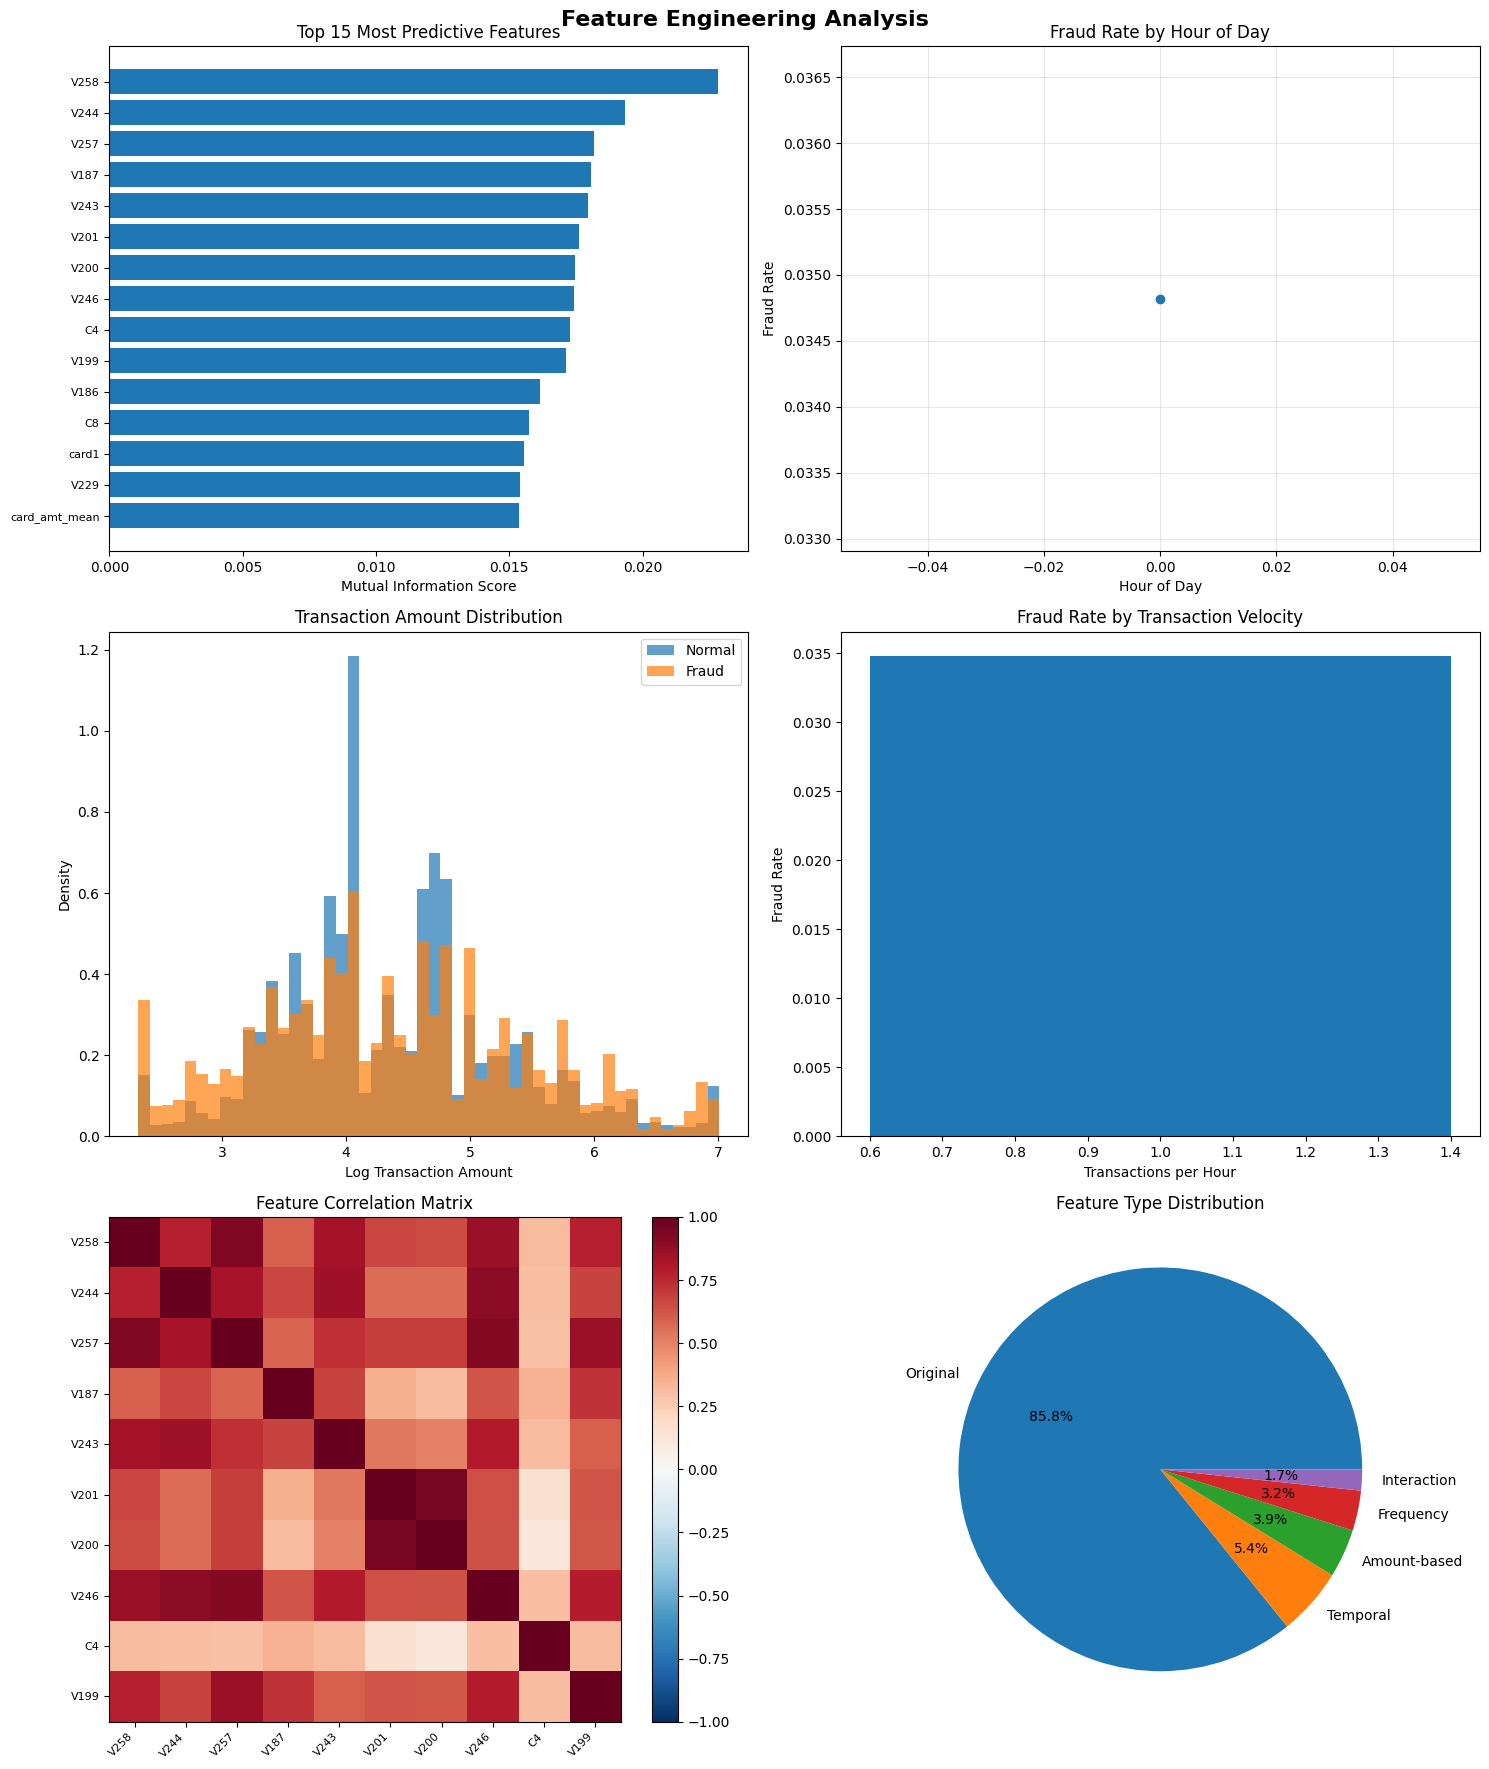


6. DETAILED FEATURE ANALYSIS

--- V258 ---
Fraud mean: 2.6817
Normal mean: 1.1329
Difference: 1.5488
Correlation with fraud: 0.4832

--- V244 ---
Fraud mean: 1.7194
Normal mean: 1.0390
Difference: 0.6804
Correlation with fraud: 0.4425

--- V257 ---
Fraud mean: 2.3547
Normal mean: 1.1002
Difference: 1.2544
Correlation with fraud: 0.4745

--- V187 ---
Fraud mean: 1.9549
Normal mean: 1.0945
Difference: 0.8604
Correlation with fraud: 0.2796

--- V243 ---
Fraud mean: 1.8191
Normal mean: 1.0600
Difference: 0.7591
Correlation with fraud: 0.4372

--- V201 ---
Fraud mean: 2.0176
Normal mean: 1.0148
Difference: 1.0028
Correlation with fraud: 0.4092

--- V200 ---
Fraud mean: 1.8973
Normal mean: 1.0010
Difference: 0.8962
Correlation with fraud: 0.3917

--- V246 ---
Fraud mean: 2.0317
Normal mean: 1.0673
Difference: 0.9644
Correlation with fraud: 0.4580

--- C4 ---
Fraud mean: 1.4376
Normal mean: 0.2997
Difference: 1.1379
Correlation with fraud: 0.2501

--- V199 ---
Fraud mean: 2.1028
Normal mean:

In [50]:
# FEATURE EXPLORATION AND ANALYSIS
def explore_engineered_features(train_df, test_df):
    """Comprehensive exploration of engineered features"""
    
    print("="*60)
    print("FEATURE ENGINEERING ANALYSIS")
    print("="*60)
    
    # 1. Basic Statistics
    print(f"\n1. DATASET OVERVIEW")
    print(f"Training set: {train_df.shape[0]:,} rows, {train_df.shape[1]:,} features")
    print(f"Test set: {test_df.shape[0]:,} rows, {test_df.shape[1]:,} features")
    print(f"Fraud rate: {train_df['isFraud'].mean():.4f}")
    
    # 2. Feature Categories
    print(f"\n2. FEATURE CATEGORIES")
    feature_categories = {
        'temporal': [col for col in train_df.columns if any(x in col.lower() for x in ['hour', 'day', 'week', 'time', 'velocity', 'sin', 'cos'])],
        'amount': [col for col in train_df.columns if any(x in col.lower() for x in ['amt', 'amount', 'transaction'])],
        'device': [col for col in train_df.columns if any(x in col.lower() for x in ['device', 'browser', 'screen', 'mobile', 'desktop'])],
        'frequency': [col for col in train_df.columns if any(x in col.lower() for x in ['fraud_rate', 'frequency'])],
        'interaction': [col for col in train_df.columns if any(x in col.lower() for x in ['interaction', 'combo'])],
        'anomaly': [col for col in train_df.columns if any(x in col.lower() for x in ['anomaly', 'zscore', 'outlier', 'consistency'])]
    }
    
    for category, features in feature_categories.items():
        if features:
            print(f"{category.upper()}: {len(features)} features")
            print(f"  Examples: {features[:3]}...")
    
    # 3. Missing Value Analysis
    print(f"\n3. MISSING VALUES ANALYSIS")
    missing_stats = train_df.isnull().sum()
    missing_features = missing_stats[missing_stats > 0].sort_values(ascending=False)
    if len(missing_features) > 0:
        print(f"Features with missing values: {len(missing_features)}")
        print(missing_features.head(10))
    else:
        print("No missing values found!")
    
    return feature_categories

def analyze_feature_importance(train_df, sample_size=10000):
    """Analyze which features are most predictive of fraud"""
    
    print(f"\n4. FEATURE IMPORTANCE ANALYSIS")
    
    # Sample data for faster computation
    if len(train_df) > sample_size:
        sample_df = train_df.sample(n=sample_size, random_state=42)
    else:
        sample_df = train_df.copy()
    
    # Select numeric features only
    numeric_features = sample_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_features = [col for col in numeric_features if col != 'isFraud']
    
    print(f"Analyzing {len(numeric_features)} numeric features...")
    
    # Calculate mutual information
    from sklearn.feature_selection import mutual_info_classif
    
    X = sample_df[numeric_features].fillna(0)
    y = sample_df['isFraud']
    
    mi_scores = mutual_info_classif(X, y, random_state=42)
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': numeric_features,
        'mutual_info': mi_scores
    }).sort_values('mutual_info', ascending=False)
    
    print("\nTop 15 Most Predictive Features:")
    print(importance_df.head(15).to_string(index=False))
    
    return importance_df

def create_feature_visualizations(train_df, importance_df):
    """Create visualizations to understand feature patterns"""
    
    print(f"\n5. CREATING VISUALIZATIONS...")
    
    # Set up the plotting area
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Feature Engineering Analysis', fontsize=16, fontweight='bold')
    
    # 1. Feature Importance Plot
    top_features = importance_df.head(15)
    axes[0,0].barh(range(len(top_features)), top_features['mutual_info'])
    axes[0,0].set_yticks(range(len(top_features)))
    axes[0,0].set_yticklabels(top_features['feature'], fontsize=8)
    axes[0,0].set_xlabel('Mutual Information Score')
    axes[0,0].set_title('Top 15 Most Predictive Features')
    axes[0,0].invert_yaxis()
    
    # 2. Fraud Rate by Hour
    if 'TransactionDT_hour' in train_df.columns:
        hourly_fraud = train_df.groupby('TransactionDT_hour')['isFraud'].agg(['mean', 'count']).reset_index()
        axes[0,1].plot(hourly_fraud['TransactionDT_hour'], hourly_fraud['mean'], marker='o')
        axes[0,1].set_xlabel('Hour of Day')
        axes[0,1].set_ylabel('Fraud Rate')
        axes[0,1].set_title('Fraud Rate by Hour of Day')
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Transaction Amount Distribution
    if 'TransactionAmt_log' in train_df.columns:
        fraud_amounts = train_df[train_df['isFraud'] == 1]['TransactionAmt_log']
        normal_amounts = train_df[train_df['isFraud'] == 0]['TransactionAmt_log'].sample(len(fraud_amounts))
        
        axes[1,0].hist(normal_amounts, bins=50, alpha=0.7, label='Normal', density=True)
        axes[1,0].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', density=True)
        axes[1,0].set_xlabel('Log Transaction Amount')
        axes[1,0].set_ylabel('Density')
        axes[1,0].set_title('Transaction Amount Distribution')
        axes[1,0].legend()
    
    # 4. Velocity Analysis
    if 'velocity_1h' in train_df.columns:
        velocity_fraud = train_df.groupby('velocity_1h')['isFraud'].mean().reset_index()
        velocity_fraud = velocity_fraud[velocity_fraud['velocity_1h'] <= 20]  # Limit for readability
        axes[1,1].bar(velocity_fraud['velocity_1h'], velocity_fraud['isFraud'])
        axes[1,1].set_xlabel('Transactions per Hour')
        axes[1,1].set_ylabel('Fraud Rate')
        axes[1,1].set_title('Fraud Rate by Transaction Velocity')
    
    # 5. Feature Correlation Heatmap
    top_10_features = importance_df.head(10)['feature'].tolist()
    if len(top_10_features) >= 2:
        corr_matrix = train_df[top_10_features].corr()
        im = axes[2,0].imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        axes[2,0].set_xticks(range(len(top_10_features)))
        axes[2,0].set_yticks(range(len(top_10_features)))
        axes[2,0].set_xticklabels([f.replace('_', '\n') for f in top_10_features], rotation=45, ha='right', fontsize=8)
        axes[2,0].set_yticklabels([f.replace('_', '\n') for f in top_10_features], fontsize=8)
        axes[2,0].set_title('Feature Correlation Matrix')
        plt.colorbar(im, ax=axes[2,0])
    
    # 6. Feature Type Distribution
    feature_counts = {
        'Original': len([col for col in train_df.columns if not any(x in col for x in ['_log', '_sqrt', '_sin', '_cos', 'velocity', 'fraud_rate', 'interaction'])]),
        'Temporal': len([col for col in train_df.columns if any(x in col for x in ['hour', 'day', 'velocity', 'sin', 'cos'])]),
        'Amount-based': len([col for col in train_df.columns if any(x in col for x in ['_log', '_sqrt', 'amt_'])]),
        'Frequency': len([col for col in train_df.columns if 'fraud_rate' in col or 'frequency' in col]),
        'Interaction': len([col for col in train_df.columns if 'interaction' in col or 'combo' in col])
    }
    
    axes[2,1].pie(feature_counts.values(), labels=feature_counts.keys(), autopct='%1.1f%%')
    axes[2,1].set_title('Feature Type Distribution')
    
    plt.tight_layout()
    plt.show()

def analyze_feature_patterns(train_df, importance_df):
    """Deep dive into specific feature patterns"""
    
    print(f"\n6. DETAILED FEATURE ANALYSIS")
    
    # Get top features for analysis
    top_features = importance_df.head(10)['feature'].tolist()
    
    for feature in top_features:
        if feature in train_df.columns:
            print(f"\n--- {feature} ---")
            
            # Basic statistics
            fraud_mean = train_df[train_df['isFraud'] == 1][feature].mean()
            normal_mean = train_df[train_df['isFraud'] == 0][feature].mean()
            
            print(f"Fraud mean: {fraud_mean:.4f}")
            print(f"Normal mean: {normal_mean:.4f}")
            print(f"Difference: {abs(fraud_mean - normal_mean):.4f}")
            
            # Correlation with fraud
            correlation = train_df[feature].corr(train_df['isFraud'])
            print(f"Correlation with fraud: {correlation:.4f}")

def generate_insights_summary(train_df, importance_df, feature_categories):
    """Generate actionable insights from the analysis"""
    
    print(f"\n" + "="*60)
    print("KEY INSIGHTS & RECOMMENDATIONS")
    print("="*60)
    
    insights = []
    
    # 1. Most important feature category
    category_importance = {}
    for category, features in feature_categories.items():
        category_features = [f for f in features if f in importance_df['feature'].values]
        if category_features:
            avg_importance = importance_df[importance_df['feature'].isin(category_features)]['mutual_info'].mean()
            category_importance[category] = avg_importance
    
    if category_importance:
        best_category = max(category_importance, key=category_importance.get)
        insights.append(f"• {best_category.upper()} features are most predictive (avg importance: {category_importance[best_category]:.4f})")
    
    # 2. Top individual features
    top_3_features = importance_df.head(3)['feature'].tolist()
    insights.append(f"• Top 3 features: {', '.join(top_3_features)}")
    
    # 3. Feature engineering success
    original_features = [col for col in train_df.columns if col in ['TransactionAmt', 'TransactionDT', 'card1', 'card2', 'card3']]
    engineered_in_top_10 = len([f for f in importance_df.head(10)['feature'] if f not in original_features])
    insights.append(f"• {engineered_in_top_10}/10 top features are engineered (shows feature engineering success)")
    
    # 4. Data quality
    missing_rate = train_df.isnull().sum().sum() / (train_df.shape[0] * train_df.shape[1])
    insights.append(f"• Overall missing data rate: {missing_rate:.2%}")
    
    # 5. Fraud patterns
    if 'TransactionDT_hour' in train_df.columns:
        night_fraud_rate = train_df[train_df['is_night'] == 1]['isFraud'].mean()
        day_fraud_rate = train_df[train_df['is_night'] == 0]['isFraud'].mean()
        if night_fraud_rate > day_fraud_rate * 1.2:
            insights.append(f"• Night transactions are {night_fraud_rate/day_fraud_rate:.1f}x more likely to be fraud")
    
    print("\nKEY FINDINGS:")
    for insight in insights:
        print(insight)
    
    print(f"\nNEXT STEPS:")
    print(f"• Consider feature selection to reduce dimensionality")
    print(f"• Try different ML algorithms (Random Forest, XGBoost, Neural Networks)")
    print(f"• Implement cross-validation for robust model evaluation")
    print(f"• Consider ensemble methods combining multiple models")

# Execute the complete analysis
print("Executing comprehensive feature analysis...")

feature_categories = explore_engineered_features(train_engineered, test_engineered)
importance_df = analyze_feature_importance(train_engineered)
create_feature_visualizations(train_engineered, importance_df)
analyze_feature_patterns(train_engineered, importance_df)
generate_insights_summary(train_engineered, importance_df, feature_categories)

In [ ]:

import pandas as pd
import os
import numpy as np
from scipy import stats
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
# Check if files exist
train_path = '../data/feature_engineered/train_final_feature_selection.csv'
test_path = '../data/feature_engineered/test_final_feature_selection.csv'

if os.path.exists(train_path) and os.path.exists(test_path):
    print("📂 Loading saved engineered datasets...")
    train_engineered = pd.read_csv(train_path)
    test_engineered = pd.read_csv(test_path)
    print(f"✅ Loaded train: {train_engineered.shape}")
    print(f"✅ Loaded test: {test_engineered.shape}")
else:
    print("❌ Saved files not found. Need to run feature engineering first.")
    # Run the pipeline
    train_engineered, test_engineered = complete_feature_engineering_pipeline(train_data, test_data)


# FEATURE COUNT ANALYSIS
def analyze_dataset_features(train_df, test_df, detailed=True):
    """
    Comprehensive analysis of features in training and test datasets
    """
    print("🔍 DATASET FEATURE ANALYSIS")
    print("=" * 60)
    
    # Basic feature counts
    train_features = train_df.shape[1]
    test_features = test_df.shape[1]
    train_samples = train_df.shape[0]
    test_samples = test_df.shape[0]
    
    print(f"\n📊 BASIC STATISTICS:")
    print(f"Training Dataset:")
    print(f"  • Samples: {train_samples:,}")
    print(f"  • Features: {train_features:,}")
    print(f"  • Total data points: {train_samples * train_features:,}")
    
    print(f"\nTest Dataset:")
    print(f"  • Samples: {test_samples:,}")
    print(f"  • Features: {test_features:,}")
    print(f"  • Total data points: {test_samples * test_features:,}")
    
    # Check if target column exists
    target_in_train = 'isFraud' in train_df.columns
    target_in_test = 'isFraud' in test_df.columns
    
    if target_in_train:
        feature_count_train = train_features - 1  # Exclude target
        print(f"\n🎯 FEATURE COUNT (excluding target):")
        print(f"  • Training features: {feature_count_train:,}")
    else:
        feature_count_train = train_features
        print(f"\n🎯 FEATURE COUNT:")
        print(f"  • Training features: {feature_count_train:,}")
    
    if target_in_test:
        feature_count_test = test_features - 1
        print(f"  • Test features: {feature_count_test:,}")
    else:
        feature_count_test = test_features
        print(f"  • Test features: {feature_count_test:,}")
    
    # Check feature alignment
    train_cols = set(train_df.columns)
    test_cols = set(test_df.columns)
    
    if target_in_train:
        train_cols.discard('isFraud')
    if target_in_test:
        test_cols.discard('isFraud')
    
    common_features = train_cols.intersection(test_cols)
    train_only = train_cols - test_cols
    test_only = test_cols - train_cols
    
    print(f"\n🔄 FEATURE ALIGNMENT:")
    print(f"  • Common features: {len(common_features):,}")
    print(f"  • Train-only features: {len(train_only):,}")
    print(f"  • Test-only features: {len(test_only):,}")
    
    if detailed:
        # Feature type analysis
        print(f"\n📈 FEATURE TYPE BREAKDOWN:")
        
        # Analyze data types in training set
        dtype_counts = train_df.dtypes.value_counts()
        print(f"Training dataset data types:")
        for dtype, count in dtype_counts.items():
            print(f"  • {dtype}: {count:,} features")
        
        # Categorical vs Numerical
        numeric_features = train_df.select_dtypes(include=[np.number]).columns
        categorical_features = train_df.select_dtypes(include=['object', 'category']).columns
        
        # Exclude target if present
        if 'isFraud' in numeric_features:
            numeric_features = numeric_features.drop('isFraud')
        if 'isFraud' in categorical_features:
            categorical_features = categorical_features.drop('isFraud')
        
        print(f"\nFeature categories:")
        print(f"  • Numerical: {len(numeric_features):,}")
        print(f"  • Categorical: {len(categorical_features):,}")
        
        # Memory usage
        train_memory = train_df.memory_usage(deep=True).sum() / 1024**2  # MB
        test_memory = test_df.memory_usage(deep=True).sum() / 1024**2   # MB
        
        print(f"\n💾 MEMORY USAGE:")
        print(f"  • Training dataset: {train_memory:.2f} MB")
        print(f"  • Test dataset: {test_memory:.2f} MB")
        print(f"  • Total memory: {train_memory + test_memory:.2f} MB")
        
        # Show misaligned features if any
        if train_only:
            print(f"\n⚠️  TRAIN-ONLY FEATURES ({len(train_only)}):")
            for i, feature in enumerate(sorted(train_only)):
                if i < 10:  # Show first 10
                    print(f"  • {feature}")
                elif i == 10:
                    print(f"  • ... and {len(train_only) - 10} more")
                    break
        
        if test_only:
            print(f"\n⚠️  TEST-ONLY FEATURES ({len(test_only)}):")
            for i, feature in enumerate(sorted(test_only)):
                if i < 10:  # Show first 10
                    print(f"  • {feature}")
                elif i == 10:
                    print(f"  • ... and {len(test_only) - 10} more")
                    break
    
    # Summary statistics
    if target_in_train:
        fraud_rate = train_df['isFraud'].mean()
        fraud_count = train_df['isFraud'].sum()
        normal_count = len(train_df) - fraud_count
        
        print(f"\n🎯 TARGET ANALYSIS:")
        print(f"  • Fraud rate: {fraud_rate:.4f} ({fraud_rate:.2%})")
        print(f"  • Fraud cases: {fraud_count:,}")
        print(f"  • Normal cases: {normal_count:,}")
        print(f"  • Class imbalance ratio: 1:{normal_count/fraud_count:.1f}")
    
    # Feature density (non-null values)
    train_density = (train_df.count().sum()) / (train_df.shape[0] * train_df.shape[1])
    test_density = (test_df.count().sum()) / (test_df.shape[0] * test_df.shape[1])
    
    print(f"\n📊 DATA COMPLETENESS:")
    print(f"  • Training density: {train_density:.2%}")
    print(f"  • Test density: {test_density:.2%}")
    
    return {
        'train_features': feature_count_train,
        'test_features': feature_count_test,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'common_features': len(common_features),
        'train_only': len(train_only),
        'test_only': len(test_only),
        'train_memory_mb': train_memory if detailed else None,
        'test_memory_mb': test_memory if detailed else None
    }

# Quick feature count function
def quick_feature_count(train_df, test_df):
    """Quick feature count without detailed analysis"""
    
    train_features = train_df.shape[1] - (1 if 'isFraud' in train_df.columns else 0)
    test_features = test_df.shape[1] - (1 if 'isFraud' in test_df.columns else 0)
    
    print(f"🔢 QUICK FEATURE COUNT:")
    print(f"Training features: {train_features:,}")
    print(f"Test features: {test_features:,}")
    print(f"Feature difference: {abs(train_features - test_features):,}")
    
    return train_features, test_features

# Execute the analysis
print("Analyzing your engineered datasets...\n")

# Detailed analysis
feature_stats = analyze_dataset_features(train_engineered, test_engineered, detailed=True)

# Also show quick count
print("\n" + "="*60)
train_feat_count, test_feat_count = quick_feature_count(train_engineered, test_engineered)

📂 Loading saved engineered datasets...


/var/folders/7f/lz8t8yrj0755nqv_kddd2ps00000gn/T/ipykernel_1742/1742942522.py:13: DtypeWarning: Columns (16,46,47,48,50,51,52,53,54,424,425,432,436,437,438,439,440,442,443,444,445,446,447,448,449) have mixed types. Specify dtype option on import or set low_memory=False.
  train_engineered = pd.read_csv(train_path)
/var/folders/7f/lz8t8yrj0755nqv_kddd2ps00000gn/T/ipykernel_1742/1742942522.py:14: DtypeWarning: Columns (45,46,47,49,50,51,52,53,431,435,438,441,442) have mixed types. Specify dtype option on import or set low_memory=False.
  test_engineered = pd.read_csv(test_path)


✅ Loaded train: (593424, 516)
✅ Loaded test: (506691, 506)
Analyzing your engineered datasets...

🔍 DATASET FEATURE ANALYSIS

📊 BASIC STATISTICS:
Training Dataset:
  • Samples: 593,424
  • Features: 516
  • Total data points: 306,206,784

Test Dataset:
  • Samples: 506,691
  • Features: 506
  • Total data points: 256,385,646

🎯 FEATURE COUNT (excluding target):
  • Training features: 515
  • Test features: 506

🔄 FEATURE ALIGNMENT:
  • Common features: 468
  • Train-only features: 47
  • Test-only features: 38

📈 FEATURE TYPE BREAKDOWN:
Training dataset data types:
  • float64: 451 features
  • object: 35 features
  • int64: 30 features

Feature categories:
  • Numerical: 480
  • Categorical: 35

💾 MEMORY USAGE:
  • Training dataset: 3083.63 MB
  • Test dataset: 2611.02 MB
  • Total memory: 5694.65 MB

⚠️  TRAIN-ONLY FEATURES (47):
  • amt_zscore
  • id_01
  • id_02
  • id_03
  • id_04
  • id_05
  • id_06
  • id_07
  • id_08
  • id_09
  • ... and 37 more

⚠️  TEST-ONLY FEATURES (38):
 

In [ ]:
# Load the previously saved engineered datasets
import pandas as pd
import os

# Check if files exist
train_path = '../data/feature_engineered/train_final_engineered.csv'
test_path = '../data/feature_engineered/test_final_engineered.csv'

if os.path.exists(train_path) and os.path.exists(test_path):
    print("📂 Loading saved engineered datasets...")
    train_engineered = pd.read_csv(train_path)
    test_engineered = pd.read_csv(test_path)
    print(f"✅ Loaded train: {train_engineered.shape}")
    print(f"✅ Loaded test: {test_engineered.shape}")
else:
    print("❌ Saved files not found. Need to run feature engineering first.")
    # Run the pipeline
    train_engineered, test_engineered = complete_feature_engineering_pipeline(train_data, test_data)